In [1]:
from torch_geometric.datasets import Planetoid
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj
dataset = Planetoid("../datasets/Cora", "Cora")
data = dataset[0]

In [2]:
from graph_hscn.layer.sc_layer import SCLayer

In [3]:
from graph_hscn.loader.dataset.peptides_structural import PeptidesStructuralDataset

In [4]:
data = PeptidesStructuralDataset("../datasets/peptides_structural")

In [5]:
data = data.data

In [6]:
data.edge_index

tensor([[ 0,  1,  1,  ..., 65, 65, 66],
        [ 1,  0,  2,  ..., 62, 66, 65]])

In [7]:
data.num_nodes

2344859

In [8]:
sc = SCLayer([9, 9], "ReLU", 2344859, 3, [9, 9])
clusters, mc_loss, o_loss = sc(data.x.float(), data.edge_index.type(torch.int64), data.edge_weight)

import matplotlib.pyplot as plt
plt.hist(clusters.argmax(axis=1))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2344859x9 and 2344859x9)

In [35]:
mc_loss + o_loss

tensor(-0.0774, grad_fn=<AddBackward0>)

(array([  74.,    0.,    0.,    0.,    0.,  333.,    0.,    0.,    0.,
        2301.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

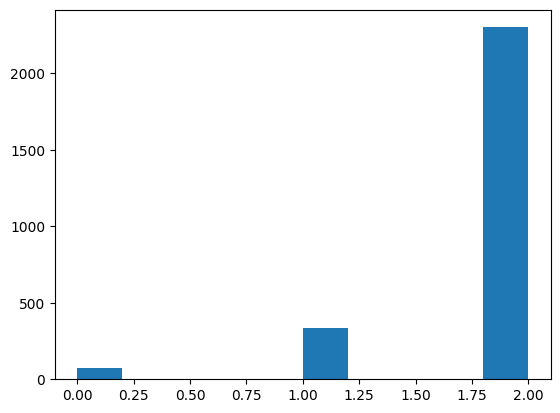

In [44]:
class SparseAttention(nn.Module):
    def __init__(self, in_channels, out_channels, num_clusters, num_heads, concat=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_clusters = num_clusters
        self.num_heads = num_heads
        self.concat = concat

        self.weight = nn.Parameter(torch.Tensor(num_heads, in_channels, out_channels))
        self.bias = nn.Parameter(torch.Tensor(num_heads, out_channels))
        self.reset_parameters()

        self.cluster_weight = nn.Parameter(torch.Tensor(num_clusters, num_heads, out_channels))
        self.cluster_bias = nn.Parameter(torch.Tensor(num_heads, out_channels))
        self.reset_cluster_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def reset_cluster_parameters(self):
        nn.init.xavier_uniform_(self.cluster_weight)
        nn.init.zeros_(self.cluster_bias)

    def forward(self, x, edge_index):
        num_nodes = x.size(0)
        print(x.shape, self.cluster_weight.shape)
        attn_coeffs = torch.einsum("ij,hjk->hik", x, self.cluster_weight) + self.cluster_bias
        attn_coeffs = F.softmax(attn_coeffs, dim=1)
        x = torch.einsum("ij,hjk->hik", x, attn_coeffs * self.weight) * self.bias
        x = F.relu(x)

        adj = to_dense_adj(edge_index)[0]

        deg = torch.sum(adj, dim=1, keepdim=True)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[torch.isinf(deg_inv_sqrt)] = 0
        norm_adj = adj * deg_inv_sqrt * deg_inv_sqrt.t()

        output = []

        for i in range(self.num_heads):
            h = torch.mm(norm_adj, x[i])
            output.append(h)

        if self.concat:
            x = torch.cat(output, dim=-1)
        else:
            x = torch.stack(output, dim=0)

        return x

In [45]:
sp = SparseAttention(3, 16, 3, 3)
sp(clusters, data.edge_index)

torch.Size([2708, 4]) torch.Size([3, 3, 16])


RuntimeError: einsum(): subscript j has size 3 for operand 1 which does not broadcast with previously seen size 4

(array([2704.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           4.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

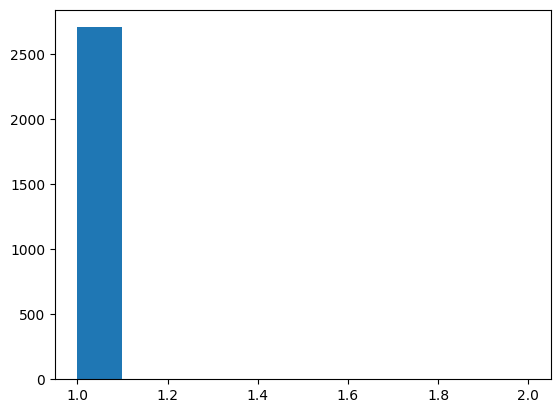

In [21]:
clusters.shape

torch.Size([2708, 3])

In [23]:
data.edge_index.shape

torch.Size([2, 10556])